In [1]:
! pip install torchinfo

In [2]:
import os 
import random 
from datetime import date
from tqdm import tqdm
from copy import deepcopy
import numpy as np 
import pandas as pd

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import weight_norm
from torch.optim import Adam, Adagrad
from torch.nn import MSELoss

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

import torchinfo  # get model view

In [3]:
from src.datasets.data import PAMAP2Reader
# from src.datasets.dataset import PAMAP2Dataset

from src.models.ts_transformer import RelativeGlobalAttention
from src.models.loss import FeatureLoss, AttributeLoss 
from src.utils.losses import SupConLoss

from src.utils.analysis import action_evaluator

In [4]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "RelativeGlobalAttention",
    "sem-space": 'attr',
    # model training configs
    "include_attribute_loss": True, 
    "semantic_size": 128,
    "n_actions": 18,
    "folding": True,
    "lr": 0.001,
    'imu_lr': 0.0001,
    'ae_lr': 0.005,
    'imu_alpha': 0.6,
    'ae_alpha': 0.7,
    "n_epochs": 5,
    "optimizer": "adam",
    "batch_size": 32,
    "semantic_loss": "cosine_distance",
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "feat_size": 64, # skel-AE hidden size and IMU-Anc output size
    # dataset configs
    "window_size": 5, 
    "overlap": 0.5,
    "seq_len": 50,  # skeleton seq. length
    "seen_split": 0.2,
    "unseen_split": 0.8
}

---

In [5]:
class Model6a(nn.Module):
    def __init__(self, in_ft, d_model, num_heads, ft_size, n_classes, max_len=1024, dropout=0.1):
        super(Model6a, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        # feature prep layer
        self.DenseL = nn.Linear(in_ft, d_model)
        # relative global attention layer
        self.AttnL = RelativeGlobalAttention(self.d_model, self.num_heads, self.max_len)
        # positional encoding concat <-> 1DConv 
        self.Act = F.relu  # _get_activation_fn(activation)
        self.AvgPoolL = nn.AvgPool2d((self.max_len,1))
        self.DenseL2 = nn.Linear(self.d_model, self.ft_size)
        self.dropout = nn.Dropout1d(dropout)
        self.logist = nn.Linear(self.ft_size, self.n_classes)

    def forward(self, x):
        out = self.DenseL(x)
        out = self.AttnL(out)
        out = self.Act(out)
        out = self.AvgPoolL(out)
        out = torch.squeeze(out)
        out = self.dropout(out)
        out1 = self.DenseL2(out)   
        out = self.logist(out1)     
        return out, out1

In [6]:
imu_model = Model6a(in_ft=42, d_model=128, num_heads=1, ft_size=64, n_classes=18, max_len=120, dropout=0.1)

In [7]:
torchinfo.summary(imu_model, input_size=(32, 120, 42), col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
Model6a                                  [32, 120, 42]             [32, 18]                  --                        --                        --
├─Linear: 1-1                            [32, 120, 42]             [32, 120, 128]            5,504                     --                        176,128
├─RelativeGlobalAttention: 1-2           [32, 120, 128]            [32, 120, 128]            15,360                    --                        --
│    └─Linear: 2-1                       [32, 120, 128]            [32, 120, 128]            16,512                    --                        528,384
│    └─Linear: 2-2                       [32, 120, 128]            [32, 120, 128]            16,512                    --                        528,384
│    └─Linear: 2-3                       [32, 120, 128]            [32, 120, 128]         

---

In [8]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)
    
class TCNEnc(nn.Module):
    def __init__(self, seq_len=50,num_features=36, num_channels=[20,20,20,4], embedding_size=128, kernel_size=3, dropout=0.3):
        super(TCNEnc, self).__init__()
        self.seq_len = seq_len
        self.num_features = num_features
        self.num_channels = num_channels
        self.embedding_size = embedding_size
        self.kernel_size = kernel_size
        self.dropout = dropout

        self.tcn = TemporalConvNet(self.seq_len, num_channels=self.num_channels, kernel_size = self.kernel_size, dropout=self.dropout)
        self.linear = nn.Linear(self.num_channels[-1]*self.num_features, self.embedding_size)

    def forward(self, x):
        # x needs to have dimension (N, C, L) in order to be passed into CNN
        output = self.tcn(x)
        output = torch.flatten(output,start_dim=1)
        output = self.linear(output)
        return output

class TCNDec(nn.Module):
    def __init__(self, seq_len=50,num_features=36, num_channels=[20,20,20], embedding_size=128, kernel_size=3, dropout=0.3,encoder_tcn_out=4):
        super(TCNDec, self).__init__()
        self.seq_len = seq_len
        self.num_features = num_features
        self.num_channels = num_channels
        self.embedding_size = embedding_size
        self.kernel_size = kernel_size
        self.dropout = dropout
        self.encoder_tcn_out =  encoder_tcn_out

        self.num_channels.append(seq_len)

        self.linear = nn.Linear(self.embedding_size,self.encoder_tcn_out*self.num_features)
        self.tcn = TemporalConvNet(self.encoder_tcn_out, num_channels=self.num_channels, kernel_size = self.kernel_size, dropout=self.dropout)

    def forward(self, x):
        # x needs to have dimension (N, C, L) in order to be passed into CNN
        output = self.linear(x)
        output = output.view(-1,self.encoder_tcn_out,self.num_features)
        output = self.tcn(output)
        return output

    
class TCNEncoderDecoder(nn.Module):
    def __init__(self, seq_len=50, num_features=36, num_channels=[20,20,20,4], embedding_size=128, kernel_size=3, dropout=0.3):
        super(TCNEncoderDecoder, self).__init__()
        self.seq_len = seq_len
        self.num_features = num_features
        self.num_channels_encoder = num_channels
        self.num_channels_decoder = num_channels[::-1][1:]
        self.embedding_size = embedding_size
        self.kernel_size = kernel_size
        self.dropout = dropout   

        self.encoder = TCNEnc(
            seq_len = self.seq_len,
            num_features = self.num_features,
            num_channels = self.num_channels_encoder,
            embedding_size = self.embedding_size,
            kernel_size = self.kernel_size,
            dropout = self.dropout)

        self.decoder = TCNDec(
            seq_len = self.seq_len,
            encoder_tcn_out= self.num_channels_encoder[-1],
            num_features = self.num_features,
            num_channels = self.num_channels_decoder,
            embedding_size = self.embedding_size,
            kernel_size = self.kernel_size,
            dropout = self.dropout)

    def forward(self, x):
        # x needs to have dimension (N, C, L) in order to be passed into CNN
        embedding = self.encoder(x)
        output = self.decoder(embedding)
        return output, embedding

In [9]:
ae_model = TCNEncoderDecoder(seq_len=50, num_features=36, num_channels=[20,20,20,4], embedding_size=256, kernel_size=3, dropout=0.3)
# prep_dir = './tmp/random_input_100_epochs.pt'

# ae_model.load_state_dict(torch.load(prep_dir))

In [10]:
torchinfo.summary(ae_model, input_size=(32, 50, 36), col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"))

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
TCNEncoderDecoder                             [32, 50, 36]              [32, 50, 36]              --                        3                         --
├─TCNEnc: 1-1                                 [32, 50, 36]              [32, 256]                 --                        3                         --
│    └─TemporalConvNet: 2-1                   [32, 50, 36]              [32, 4, 36]               --                        --                        --
│    │    └─Sequential: 3-1                   [32, 50, 36]              [32, 4, 36]               10,648                    --                        7,315,968
│    └─Linear: 2-2                            [32, 144]                 [32, 256]                 37,120                    --                        1,187,840
├─TCNDec: 1-2                                 [32, 256]      

---

In [11]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
# import PAMAP2 dataset
dt = config['dataset']
if dt == 'PAMAP2':
    dataReader = PAMAP2Reader('./data/PAMAP2_Dataset/Protocol/')

actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


g:\FYP\Codebases\Pose-AE\src\datasets\data.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [13]:
if dt == 'PAMAP2':
    fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [14]:
skeleton_data = np.load('./data/skeleton_movements.npz')
skeleton_classes, skeleton_mov = skeleton_data['arr_0'], skeleton_data['arr_1']

In [15]:
dataReader.label_map

[(1, 'lying'),
 (2, 'sitting'),
 (3, 'standing'),
 (4, 'walking'),
 (5, 'running'),
 (6, 'cycling'),
 (7, 'Nordic walking'),
 (9, 'watching TV'),
 (10, 'computer work'),
 (11, 'car driving'),
 (12, 'ascending stairs'),
 (13, 'descending stairs'),
 (16, 'vacuum cleaning'),
 (17, 'ironing'),
 (18, 'folding laundry'),
 (19, 'house cleaning'),
 (20, 'playing soccer'),
 (24, 'rope jumping')]

In [16]:
np.unique(skeleton_classes)

array(['Nordic walking', 'ascending stairs', 'car driving',
       'computer work', 'cycling', 'descending stairs', 'folding laundry',
       'house cleaning', 'ironing', 'lying', 'playing soccer',
       'rope jumping', 'running', 'sitting', 'standing',
       'vacuum cleaning', 'walking', 'watching TV'], dtype='<U17')

In [17]:
from collections import defaultdict

label2Id = {c[1]:i for i,c in enumerate(dataReader.label_map)}
action_dict = defaultdict(list)
skeleton_Ids = []
for i, a in enumerate(skeleton_classes):
    action_dict[label2Id[a]].append(i)
    skeleton_Ids.append(label2Id[a])

In [18]:
action_dict

defaultdict(list,
            {10: [0, 1, 2, 3, 4, 5],
             9: [6, 7, 8, 9],
             8: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
             5: [20, 21, 22, 23, 24],
             11: [25, 26, 27, 28, 29, 30],
             14: [31, 32, 33, 34, 35, 36, 37],
             15: [38, 39, 40, 41, 42, 43, 44],
             13: [45, 46, 47, 48, 49, 50],
             0: [51, 52],
             6: [53, 54, 55, 56, 57, 58, 59],
             16: [60, 61, 62, 63, 64],
             17: [65, 66],
             4: [67, 68, 69, 70, 71],
             1: [72, 73, 74, 75, 76, 77],
             2: [78, 79, 80, 81, 82],
             12: [83, 84, 85, 86, 87, 88],
             3: [89, 90, 91, 92],
             7: [93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104]})

---

In [19]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, attributes, attribute_dict, action_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.attribute_dict = attribute_dict
        self.seq_len = seq_len
        self.attributes = torch.from_numpy(attributes)
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        x_mask = np.array([0]) #self.padding_mask[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences 
        skel_idx = random.choice(self.attribute_dict[target])
        y_feat = self.attributes[skel_idx, ...]
        return x, y, y_feat, x_mask

    def __len__(self):
        return self.data.shape[0]

    def getClassAttrs(self):
        sampling_idx = [random.choice(self.attribute_dict[i]) for i in self.action_classes]
        ft_mat = self.attributes[sampling_idx, ...]
        return ft_mat 

In [20]:
data_dict = dataReader.generate(unseen_classes=fold_cls_ids[0], seen_ratio=0.2, unseen_ratio=0.8, window_size=5.21, window_overlap=4.21, resample_freq=20)
sample_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=skeleton_mov, attribute_dict=action_dict, action_classes=data_dict['seen_classes'], seq_len=100)
sample_dl = DataLoader(sample_dt, batch_size=32, shuffle=True, pin_memory=True, drop_last=True)
for d in sample_dl:
    print(d[0].shape)
    break

torch.Size([32, 105, 27])


In [21]:
r = sample_dt.getClassAttrs()
r.shape

torch.Size([14, 60, 36])

In [22]:
pr = F.pad(input=r, pad=(0, 0, 0, 0, 0, 18), mode='constant', value=0)
pr.shape

torch.Size([32, 60, 36])

In [23]:
torch.transpose(r[1, ...], 1, 0).shape

torch.Size([36, 60])

In [24]:
# r_out1, r_out2 = ae_model(torch.transpose(pr, 1, 0).float())
# r_out1.shape, r_out2.shape

---

In [25]:
class SkeletonDataset(Dataset):
    def __init__(self, movements, actions, action_dict, seq_len=60):
        super(SkeletonDataset, self).__init__()
        self.movements = movements[:, :seq_len, ...]
        self.actions = actions
        self.action_dict = deepcopy(dict(action_dict))
        self.actionsIDs = list(self.action_dict.keys())
        

    def __getitem__(self, idx):
        x1 = self.movements[idx, ...]
        action = self.actions[idx]

        partial_idx = random.sample(self.action_dict[action], k=1)[0]
        x2 = self.movements[partial_idx, ...]

        label = self.actionsIDs.index(action)
        # return np.transpose(x1, (1,0,2)), np.transpose(x2, (1,0,2)), label
        return x1, x2, label

    def __len__(self):
        return self.movements.shape[0]

    def getShape(self):
        return self.movements[0, ...].shape


In [26]:
action_dict

defaultdict(list,
            {10: [0, 1, 2, 3, 4, 5],
             9: [6, 7, 8, 9],
             8: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
             5: [20, 21, 22, 23, 24],
             11: [25, 26, 27, 28, 29, 30],
             14: [31, 32, 33, 34, 35, 36, 37],
             15: [38, 39, 40, 41, 42, 43, 44],
             13: [45, 46, 47, 48, 49, 50],
             0: [51, 52],
             6: [53, 54, 55, 56, 57, 58, 59],
             16: [60, 61, 62, 63, 64],
             17: [65, 66],
             4: [67, 68, 69, 70, 71],
             1: [72, 73, 74, 75, 76, 77],
             2: [78, 79, 80, 81, 82],
             12: [83, 84, 85, 86, 87, 88],
             3: [89, 90, 91, 92],
             7: [93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104]})

In [27]:
sample_dt = SkeletonDataset(skeleton_mov, skeleton_Ids, action_dict, seq_len=50)
sample_dl = DataLoader(sample_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
for b in sample_dl:
    bx1, bx2, by = b 
    # bx = torch.transpose(bx1, 1, 0)
    bs, seq_len, ft_in = bx1.shape
    print(bx1.shape)
    break 

torch.Size([32, 50, 36])


In [28]:
sample_dt.getShape()

(50, 36)

---

In [29]:
def imu_train_step1(model , ae, dataloader, optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    ae = ae.eval()

    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat, padding_masks = batch
            # print(X, targets, target_feat, target_attr)
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)
            padding_masks = padding_masks.to(device)  # 0s: ignore

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                class_output, feat_output = model(X)
            
            with torch.set_grad_enabled(False):
                _, target_feat = ae(target_feat) # batch first mode

            class_loss = loss_module['class'](class_output, targets.squeeze())
            feat_loss = loss_module['feature'](feat_output, target_feat)

            loss = loss_alpha*class_loss+(1-loss_alpha)*feat_loss

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine 
            pred_class = np.argmax(class_output.cpu().detach().numpy(), axis=1)
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)
            
    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [30]:
def ae_train_step1(model , dataloader, optimizer, loss_module, device, batch_size, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    model.to(device)

    epoch_loss = 0 
    total_samples = 0 

    with tqdm(dataloader, unit='batch', desc=phase) as tepoch:
        for batch in tepoch:
            x1, x2, labels = batch 
            # post-process 
            xa = torch.vstack([x1, x2])  # batch first mode
            # device offload 
            xa = xa.float().to(device)
            labels = labels.float()

            # set optimizer grad to zero 
            optimizer.zero_grad()
            # get model prediction 
            with torch.set_grad_enabled(phase=='train'):
                skel_output, ft_output = model(xa)

            # reconstruct the output 
            f1, f2 = torch.split(ft_output, [batch_size//2, batch_size//2], dim=0)
            cons_output = torch.stack([f1.squeeze(1), f2.squeeze(1)], dim=1)
            # calc. contrastive loss 
            con_loss = loss_module['contrast'](cons_output, labels)
            # calc. reconstruction loss 
            l2_loss = loss_module['recons'](xa, skel_output)
            # calc. total loss
            total_loss = loss_alpha*con_loss + (1-loss_alpha)*l2_loss

            if phase == 'train':
                total_loss.backward()
                optimizer.step()

            metrics = {'contrastive loss ': con_loss.item(), 'reconstruction loss': l2_loss.item()}
            with torch.no_grad():
                    total_samples += len(labels)
                    epoch_loss += total_loss.item()
            
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss/total_samples
    return metrics

In [31]:
def eval_step1(model, ae, dataloader, loss_module, device, class_names, target_feat_met, phase='seen', l2_reg=False, print_report=True, loss_alpha=0.7, batch_size=32):
    model = model.train()
    ae = ae.train()

    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}

    # generate unseen action_semantic from unseen skeleton seq. 
    ns, _, _ = target_feat_met.shape 
    padded_mat = F.pad(input=target_feat_met, pad=(0,0,0,0,0,batch_size-ns), mode='constant', value=0)
    _, vector_out = ae(padded_mat.float().to(device)) # batch second mode
    action_feat_mat = vector_out[:ns, :].cpu().detach().numpy() # batch second mode

    # print("target feat mat", target_feat_met.shap e, "action feat mat", action_feat_mat.shape)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat, padding_masks = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)
            padding_masks = padding_masks.to(device)  # 0s: ignore
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                class_output, feat_output = model(X)

            with torch.set_grad_enabled(False):
                _, target_feat = ae(target_feat) # batch second mode
                
            class_loss = loss_module['class'](class_output, targets.squeeze())
            feat_loss = loss_module['feature'](feat_output, target_feat)

            loss = loss_alpha*class_loss+(1-loss_alpha)*feat_loss

            # convert feature vector into action class
            # using cosine 
            if phase == 'seen':
                pred_action = np.argmax(class_output.cpu().detach().numpy(), axis=1)
            else:
                # print("feat output", feat_output.shape)
                feat_numpy = feat_output.cpu().detach().numpy()
                action_probs = cosine_similarity(feat_numpy, action_feat_mat)
                pred_action = np.argmax(action_probs, axis=1)
                
            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action)
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})
    
    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report)
    return metrics_dict

---

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
Initiate Skeleton dataset ... 
Initiate IMU datasets ...
Initial Models ...
Start Models training ...


seen: 100%|██████████| 130/130 [00:05<00:00, 21.67batch/s, loss=0.894]


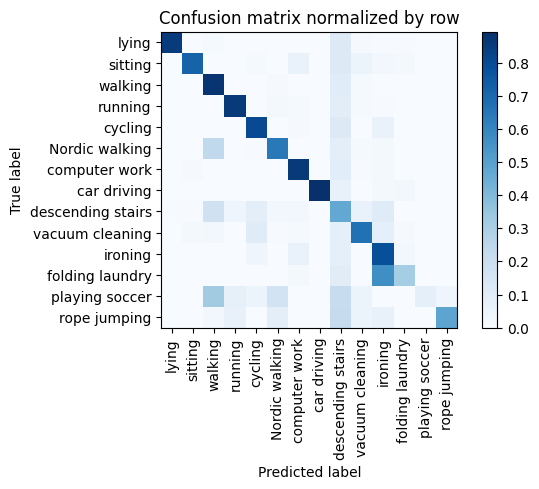

Training Epoch:  20%|██        | 1/5 [00:35<02:22, 35.64s/it]

Overall accuracy: 0.728



seen: 100%|██████████| 130/130 [00:05<00:00, 23.07batch/s, loss=0.522]


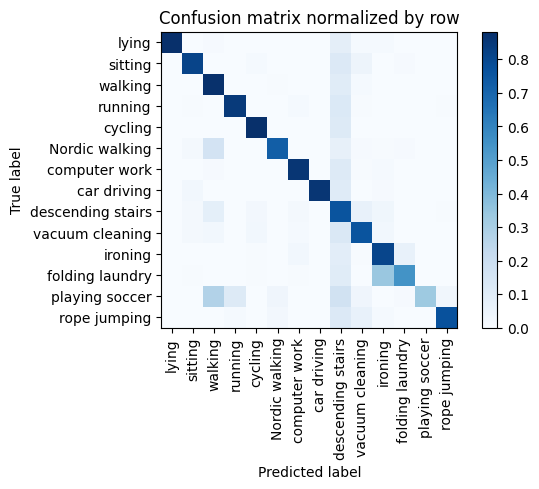

Training Epoch:  40%|████      | 2/5 [01:09<01:44, 34.74s/it]

Overall accuracy: 0.799



seen: 100%|██████████| 130/130 [00:04<00:00, 29.74batch/s, loss=0.49]


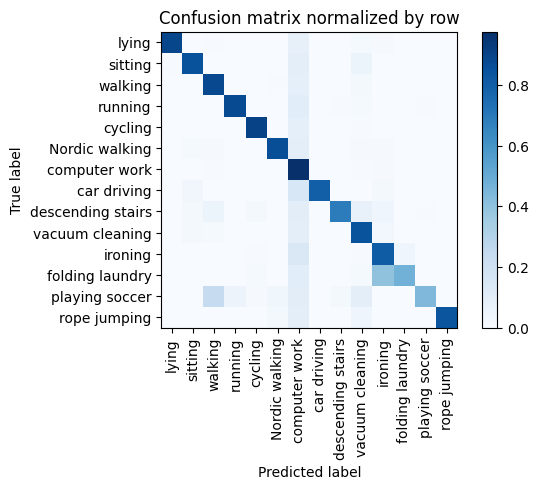

Training Epoch:  60%|██████    | 3/5 [01:37<01:02, 31.47s/it]

Overall accuracy: 0.837



seen: 100%|██████████| 130/130 [00:03<00:00, 39.03batch/s, loss=0.345]


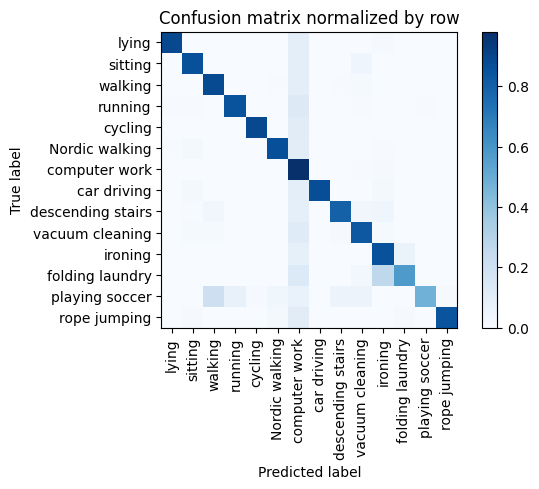

Training Epoch:  80%|████████  | 4/5 [02:00<00:28, 28.22s/it]

Overall accuracy: 0.853



seen: 100%|██████████| 130/130 [00:02<00:00, 43.72batch/s, loss=0.302]


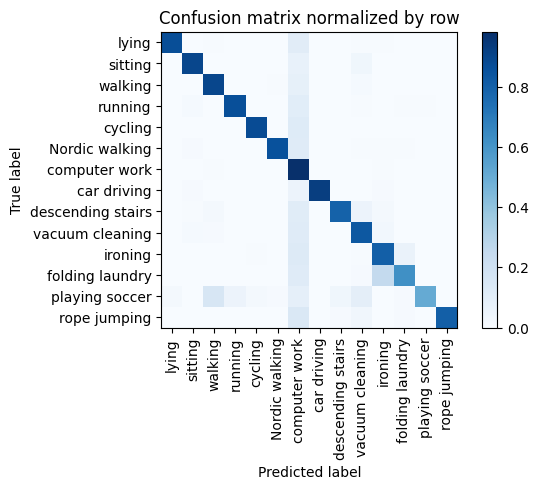

Overall accuracy: 0.854



unseen: 100%|██████████| 175/175 [00:03<00:00, 47.42batch/s, loss=3.04]


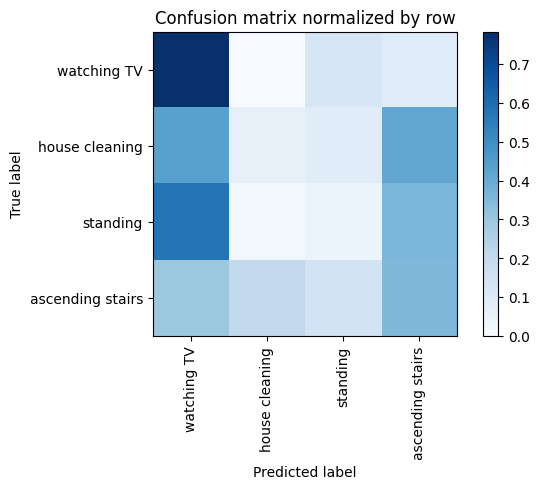

Overall accuracy: 0.218

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.153      0.042      0.066      0.330       1848|	 watching TV: 0.576,	ascending stairs: 0.363,	
  house cleaning       0.305      0.061      0.102      0.329       1842|	 watching TV: 0.436,	ascending stairs: 0.413,	standing: 0.090,	
ascending stairs       0.201      0.352      0.256      0.193       1080|	 watching TV: 0.299,	house cleaning: 0.205,	
     watching TV       0.229      0.782      0.354      0.148        830|	 standing: 0.127,	ascending stairs: 0.092,	

----------------------------------------------------------------------------------------------------
     avg / total       0.224      0.218      0.157        1.0       5600|	      

{'total_accuracy': 0.21767857142857142, 'precision': 0.2220899307673278, 'recall': 0.30919814800279655, 'f1': 0.1943783958285976}
================ Fold-1 ================
Unseen Classes : ['walking', 'ro

seen: 100%|██████████| 131/131 [00:03<00:00, 43.43batch/s, loss=0.934]


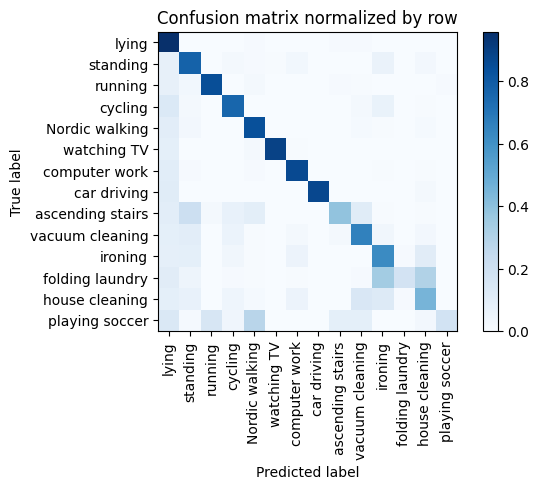

Training Epoch:  20%|██        | 1/5 [00:18<01:15, 18.86s/it]

Overall accuracy: 0.703



seen: 100%|██████████| 131/131 [00:03<00:00, 39.49batch/s, loss=0.599]


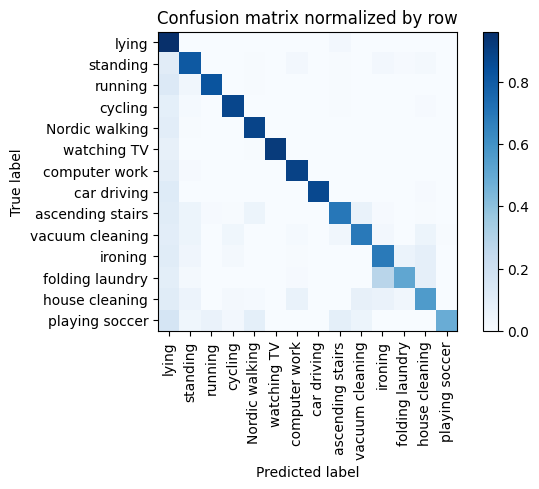

Training Epoch:  40%|████      | 2/5 [00:39<00:59, 19.95s/it]

Overall accuracy: 0.782



seen: 100%|██████████| 131/131 [00:03<00:00, 39.59batch/s, loss=0.624]


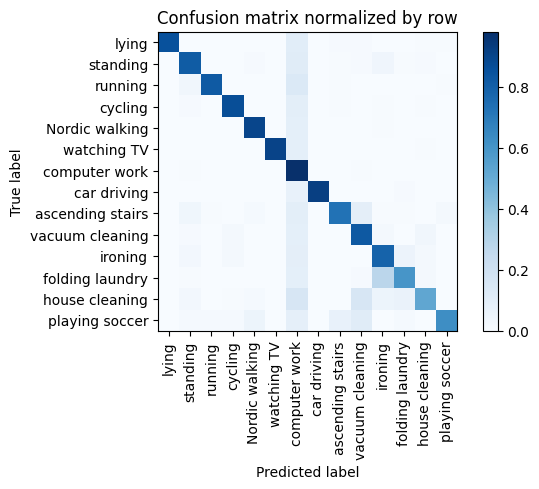

Training Epoch:  60%|██████    | 3/5 [00:59<00:39, 19.99s/it]

Overall accuracy: 0.816



seen: 100%|██████████| 131/131 [00:03<00:00, 38.95batch/s, loss=0.467]


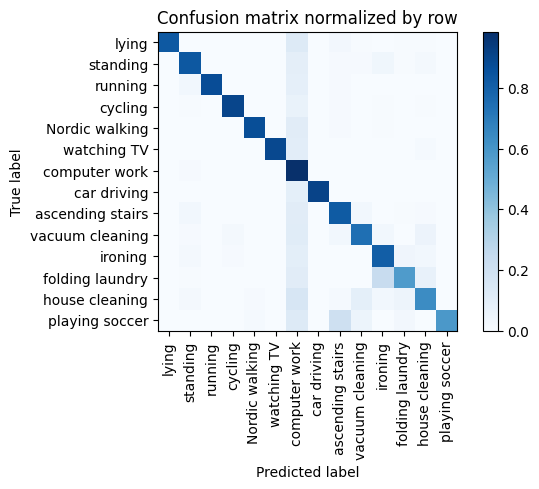

Training Epoch:  80%|████████  | 4/5 [01:19<00:20, 20.10s/it]

Overall accuracy: 0.826



seen: 100%|██████████| 131/131 [00:03<00:00, 35.70batch/s, loss=0.355]


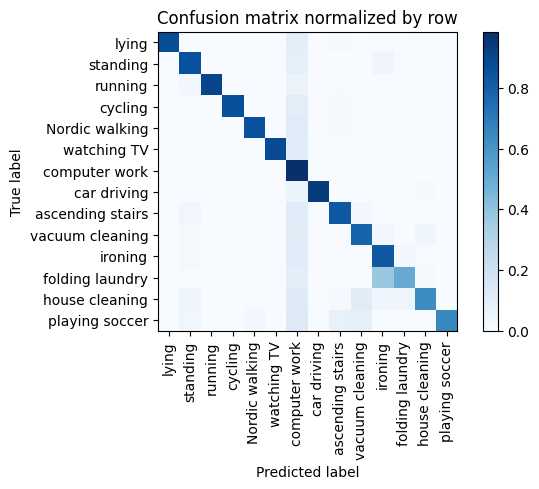

Overall accuracy: 0.834



unseen: 100%|██████████| 173/173 [00:04<00:00, 39.76batch/s, loss=3.88]


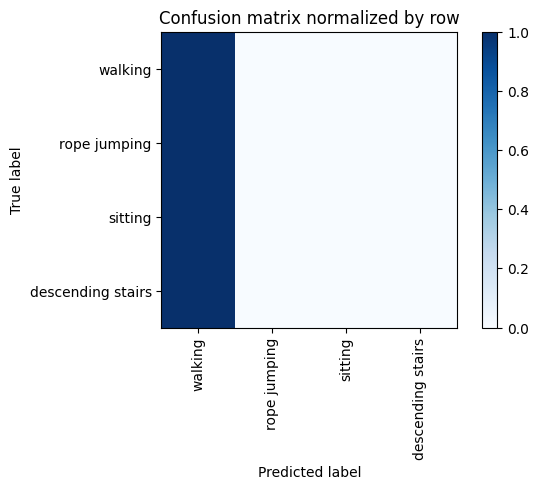

Overall accuracy: 0.421

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.421      1.000      0.592      0.421       2329|	 descending stairs: 0.000,	sitting: 0.000,	
          sitting       0.000      0.000      0.000      0.325       1797|	 walking: 1.000,	descending stairs: 0.000,	
descending stairs       0.000      0.000      0.000      0.171        949|	 walking: 1.000,	sitting: 0.000,	
     rope jumping       0.000      0.000      0.000      0.083        461|	 walking: 1.000,	descending stairs: 0.000,	sitting: 0.000,	

----------------------------------------------------------------------------------------------------
      avg / total       0.177      0.421      0.249        1.0       5536|	      

{'total_accuracy': 0.42070086705202314, 'precision': 0.10517521676300579, 'recall': 0.25, 'f1': 0.14806102987921171}
================ Fold-2 ================
Unseen Classes : ['playing soccer', 'lying', 'vacuum clea

train:  22%|██▏       | 106/485 [00:03<00:12, 30.55batch/s, loss=1.4, accuracy=0.5]


KeyboardInterrupt: 

In [33]:
prep_dir = './tmp/epoch150_randsample_input_l1.pt'

fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')
    # separate seen/unseen and train/eval 
    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=5.21, window_overlap=4.21, resample_freq=20)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']

    train_n, seq_len, in_ft = data_dict['train']['X'].shape

    print("Initiate Skeleton dataset ... ")
    # build Skeleton dataset 
    skel_dt = SkeletonDataset(skeleton_mov, skeleton_Ids, action_dict, seq_len=config['seq_len'])
    skel_dl = DataLoader(skel_dt, batch_size=config['batch_size']//2, shuffle=True, pin_memory=True, drop_last=True)
    skel_n, skel_fts = skel_dt.getShape()

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=skeleton_mov[:, :skel_n, :], attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt 
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=skeleton_mov[:, :skel_n, :], attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=skeleton_mov[:, :skel_n, :], attribute_dict=action_dict, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    
    print("Initial Models ...")
    # build IMU Encoder Model 
    imu_model = Model6a(in_ft=in_ft, d_model=config['d_model'], num_heads=config['num_heads'], ft_size=config['semantic_size'], max_len=seq_len, n_classes=len(seen_classes))
    imu_model.to(device)

    # build AE Model 
    # ae_model = BiLSTMEncDecModel(input_size=skel_fts, seq_len=skel_n, hidden_size=config['feat_size'], batch_size=config['batch_size'], ae_type='recursive', device=device)
    ae_model = TCNEncoderDecoder(seq_len=skel_n, num_features=skel_fts, num_channels=[40,40,40,30,20,4], embedding_size=config['semantic_size'], kernel_size=3, dropout=0.3)
    # ae_model.load_state_dict(torch.load(prep_dir))
    ae_model.to(device)
    
    # define IMU-Enc run parameters 
    imu_optim = Adam(imu_model.parameters(), lr=config['imu_lr'])
    # imu_optim = Adagrad(imu_model.parameters(), lr=config['lr'])
    imu_loss_module = {'class': nn.CrossEntropyLoss(), 'feature': MSELoss()}
    best_acc = 0.0

    # define AE run parameters 
    ae_optim = Adam(ae_model.parameters(), lr=config['ae_lr'])
    # ae_optim = Adagrad(ae_model.parameters(), lr=config['lr'])
    ae_loss_module = {'contrast': SupConLoss(), 'recons': nn.MSELoss()}

    print("Start Models training ...")
    # train 2 models E2E
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        # train AE model 
        ae_train_metrics = ae_train_step1(ae_model, skel_dl, ae_optim, ae_loss_module, device, config['batch_size'], phase='train', loss_alpha=config['ae_alpha'])
        # train IMU-Enc model
        train_metrics = imu_train_step1(imu_model, ae_model, train_dl, imu_optim, imu_loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=config['imu_alpha'])
        eval_metrics = eval_step1(imu_model, ae_model, eval_dl, imu_loss_module, device=device, class_names=[all_classes[i] for i in seen_classes],  target_feat_met=eval_dt.getClassAttrs(), phase='seen', print_report=False, loss_alpha=config['imu_alpha'], batch_size=config['batch_size'])
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['total_accuracy'] > best_acc:
            imu_best_model = deepcopy(imu_model.state_dict())

    # replace by best model 
    imu_model.load_state_dict(imu_best_model)

    # run evaluation on unseen classes
    test_metrics = eval_step1(imu_model, ae_model, test_dl, imu_loss_module, device=device, class_names=[all_classes[i] for i in unseen_classes],  target_feat_met=test_dt.getClassAttrs(), phase='unseen', loss_alpha=0.8, batch_size=config['batch_size'])
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
    